In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
from torchvision.transforms import transforms

In [3]:
import numpy as np
import cv2

In [4]:
from functools import partial

In [5]:
from models import Vgg16Conv
from models import Vgg16Deconv

In [6]:
from utils import decode_predictions

In [7]:
def load_images(img_path):
    # imread from img_path
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    # pytorch must normalize the pic by 
    # mean = [0.485, 0.456, 0.406]
    # std = [0.229, 0.224, 0.225]
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
    
    img = transform(img)
    img.unsqueeze_(0)
    #img_s = img.numpy()
    #img_s = np.transpose(img_s, (1, 2, 0))
    #cv2.imshow("test img", img_s)
    #cv2.waitKey()
    return img

In [8]:
def store(model):
    """
    make hook for feature map
    """
    def hook(module, input, output, key):
        if isinstance(module, nn.MaxPool2d):
           model.feature_maps[key] = output[0]
           model.pool_locs[key] = output[1]
        else:
           model.feature_maps[key] = output
    
    for idx, layer in enumerate(model._modules.get('features')):    
        # _modules returns an OrderedDict
        layer.register_forward_hook(partial(hook, key=idx))

In [9]:
def vis_layer(layer, vgg16_conv, vgg16_deconv):
    """
    visualing the layer deconv result
    """
    num_feat = vgg16_conv.feature_maps[layer].shape[1]
    
    # set other feature map activations to zero
    new_feat_map = vgg16_conv.feature_maps[layer].clone()

    # choose the max activations map
    act_lst = []
    for i in range(0, num_feat):
        choose_map = new_feat_map[0, i, :, :]
        activation = torch.max(choose_map)
        act_lst.append(activation.item())

    act_lst = np.array(act_lst)
    mark = np.argmax(act_lst)

    choose_map = new_feat_map[0, mark, :, :]
    max_activation = torch.max(choose_map)
    
    # make zeros for other feature maps
    if mark == 0:
        new_feat_map[:, 1:, :, :] = 0
    else:
        new_feat_map[:, :mark, :, :] = 0
        if mark != vgg16_conv.feature_maps[layer].shape[1] - 1:
            new_feat_map[:, mark + 1:, :, :] = 0
    
    choose_map = torch.where(choose_map==max_activation,
            choose_map,
            torch.zeros(choose_map.shape)
            )

    # make zeros for ther activations
    new_feat_map[0, mark, :, :] = choose_map
    
    # print(torch.max(new_feat_map[0, mark, :, :]))    
    print(max_activation)
    
    deconv_output = vgg16_deconv(new_feat_map, layer, mark, vgg16_conv.pool_locs)

    new_img = deconv_output.data.numpy()[0].transpose(1, 2, 0)  # (H, W, C)
    # normalize
    new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min()) * 255
    new_img = new_img.astype(np.uint8)
    # cv2.imshow('reconstruction img ' + str(layer), new_img)
    # cv2.waitKey()
    return new_img, int(max_activation)

In [10]:
# if __name__ == '__main__':

In [11]:
    # forward processing

    vgg16_conv = Vgg16Conv()
    vgg16_conv.eval()
    
    store(vgg16_conv)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\sxy1/.cache\torch\checkpoints\vgg16-397923af.pth


In [12]:
    img_path = './data/dog.jpg'
    img = load_images(img_path)

    conv_output = vgg16_conv(img)
    pool_locs = vgg16_conv.pool_locs

In [13]:
    print('Predicted:')
    print(decode_predictions(conv_output, top=3)[0])

Predicted:
[('n02108915', 'French_bulldog', 0.26950687170028687), ('n02109047', 'Great_Dane', 0.13957877457141876), ('n02096585', 'Boston_bull', 0.11346527934074402)]


In [14]:
    # backward processing
    
    vgg16_deconv = Vgg16Deconv()
    vgg16_deconv.eval()

Vgg16Deconv(
  (features): Sequential(
    (0): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (1): ReLU()
    (2): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (8): ReLU()
    (9): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (15): ReLU()
    (16): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18

In [15]:
import matplotlib
# matplotlib.use('agg')

import matplotlib.pyplot as plt

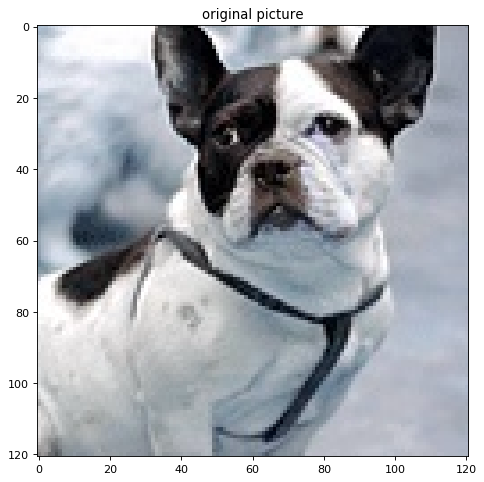

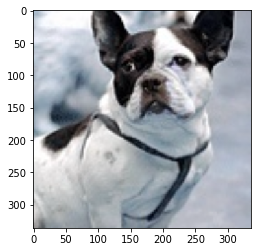

In [20]:
    plt.figure(num=None, figsize=(32, 24), dpi=80)
    plt.subplot(2, 4, 1)
    plt.title('original picture')

    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.show()
    
    # img = cv2.resize(img, (224, 224))
    img = cv2.resize(img, (336, 336))
    plt.imshow(img)
    plt.show()

tensor(66.9421, grad_fn=<MaxBackward1>)


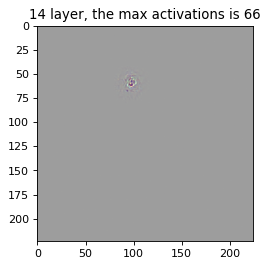

tensor(85.0446, grad_fn=<MaxBackward1>)


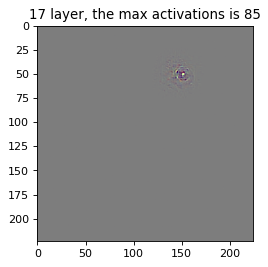

tensor(58.1469, grad_fn=<MaxBackward1>)


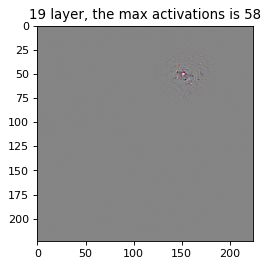

tensor(49.0105, grad_fn=<MaxBackward1>)


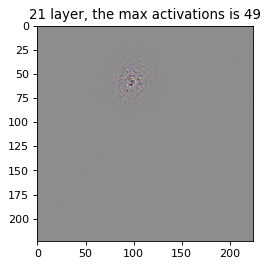

tensor(35.2904, grad_fn=<MaxBackward1>)


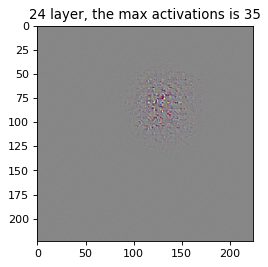

tensor(46.5080, grad_fn=<MaxBackward1>)


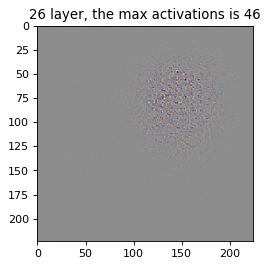

tensor(26.3481, grad_fn=<MaxBackward1>)


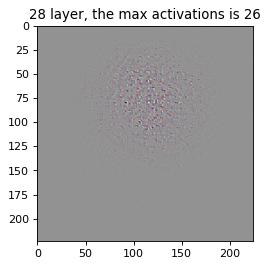

In [23]:
    for idx, layer in enumerate([14, 17, 19, 21, 24, 26, 28]):
    # for idx, layer in enumerate(vgg16_conv.conv_layer_indices):        
        
        img, activation = vis_layer(layer, vgg16_conv, vgg16_deconv)
    
        plt.figure(num=None, figsize=(16, 12), dpi=80)
        plt.subplot(2, 4, idx+1)
        plt.title(f'{layer} layer, the max activations is {activation}')
        
        # img = img[112:,112:,:]
        img = cv2.resize(img, (224, 224))
        plt.imshow(img)
        plt.show()

    # plt.show()
    # plt.savefig('result-1.jpg')
    # print('result picture has save at ./result-1.jpg')